<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb"><< Index</a>
<br>
<a href="./1_4_S6_coverage.ipynb"><< Determining Sentinel-6 coverage</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_4_S6_waveforms.ipynb">Sentinel-6 waveforms >></a>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2022 EUMETSAT <br>
**License:** MIT <br>
**Authors:** Ben Loveday (EUMETSAT/Innoflair UG), Hayley Evers-King (EUMETSAT), Vinca Rosmorduc (CLS)

<div class="alert alert-block alert-success">
<h3>Learn Sentinel-6: Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook:
- **<a href="1_1a_S6_data_access_SFTP.ipynb" target="_blank">1_1a_S6_data_access_SFTP</a>**; this will download the required Sentinel-6 products for this notebook.

</div>
<hr>

# 1.3 Sentinel-6 tracks

### Data used

| Product Description  | Data Store collection ID| Product Navigator | 
|:--------------------:|:-----------------------:|:-------------:|
| Sentinel-6 Poseidon-4 Altimetry level-2 High Resolution (NTC) | EO:EUM:DAT:0128 | <a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:0128?query=Altimetry%20NTC&filter=satellite__Sentinel-6&results=20&s=advanced" target="_blank">link</a> |

### Learning outcomes

At the end of this notebook you will know;
* What along-track altimetry data from Sentinel-6 looks like in a spatial sense.
* About range data - a fundamental altimetry measurement from which some of the geophysical products are derived.
* Which flags exist in the Sentinel-6 altimetry level-2 products, and how these can be applied.
* How to plot the level-2 geophysical variables available from Sentinel-6 altimetry level-2 products.


### Outline

At level-1 and level-2, altimetry data is fundamentally different to many other types of remote sensing data. Altimeters make measurements 'along-track', providing a single, narrow strip of data, compared to the 'image' type formats of many rows of pixels that users of optical data maybe more familiar with.  

Satellite altimetry missions determine the height of the Earth’s surface directly beneath the altimeter, by accurate measurement of distance (called "range") between the two and by precise determination of the altitude of the satellite. The range measurement is typically achieved by measuring the time it takes for a radar pulse, released by a satellite-based altimeter, to travel to a surface, reflect, and return to be recorded by an on-board detector. Unlike the passive SST and ocean colour sensors, altimetry is an active technique, as it requires the emission of a signal from the instrument itself. Thanks to this, and due to the frequencies used, it measures days and nights, and under cloudy as well as clear skies. 

This notebook, and those that follow will explore how information about the sea surface can be derived from the range and other facets of the altimetry waveforms

Within the EUMETSAT user support knowledge base you can find out more information about the **<a href='https://eumetsatspace.atlassian.net/wiki/spaces/SEN6/pages/1756299307/S6+altimetry+mission+processing+levels' target='_blank'>Sentinel-6 altimetry processing levels</a>** and **<a href='https://eumetsatspace.atlassian.net/wiki/spaces/SEN6/pages/1644036136/S6+altimetry+mission+products+file+types' target='_blank'> corresponding products</a>**.


<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>
    
 1. [Investigating Sentinel-6 tracks](#section1)
 1. [Plotting Sentinel-6 level-2 range data](#section2)
 1. [Checking Sentinel-6 level-2 flags](#section3)
 1. [Plotting Sentinel-6 level-2 geophysical variables](#section4)

<hr>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [2]:
# library imports
import cartopy
import cmocean
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import os
import warnings
import glob

warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 12})

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Reading Sentinel-6 level-2 data
[Back to top](#TOC_TOP)

</div>

First, let's open a Sentinel-6 altimetry level-2 product. As Sentinel-3, data from the altimetry mission is provided in SAFE format. Within the SAFE folder for these data sets you find several netcdf (.nc) files, these include:

* Reduced: Low resolution (1 Hz) measurements, with corrections and flags.
* Standard: Low (1 Hz) and high (20 Hz) resolution measurements, with corrections and flags.

If you download the full SAFE file, as we have done in the **<a href="1_1a_S6_data_access_SFTP.ipynb" target="_blank">1_1a_S6_data_access_SFTP</a>**, you'll receive all these netcdf files, but you can also select to just download the particular resolution that suits your application. 

For this notebook, we'll open the standard measurements file...

In [3]:
# selecting SAFE directories
SAFE_product = glob.glob(os.path.join(os.getcwd(), 'products','S6A_P4_2__HR*_NT_*','*STD*.nc'))[0]

Unlike for Sentinel-3, the data in the Sentinel-6 netCDF products is split into groups (like Jason-3). We will open each group individually

In [4]:
# read data
ds_01 = xr.open_dataset(SAFE_product, group="data_01")
ds_01_ku = xr.open_dataset(SAFE_product, group="data_01/ku")
ds_20_ku = xr.open_dataset(SAFE_product, group="data_20/ku")
ds_01.close()
ds_01_ku.close()
ds_20_ku.close()

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Plotting Sentinel-6 level-2 range data
[Back to top](#TOC_TOP)

</div>

"As mentioned above, the range is a key parameter derived from altimetry measurements, representing the distance between the satellite and Earth's surface (in this case the ocean surface). In following notebooks you'll learn more about other parameters that can be derived from the waveforms and other facets of the altimetry range, but let's take a look at what range measurements from the standard measurements file look like in a simple plot. We have a choice to make here, regarding the resolution of the product (1 Hz or 20 Hz). Sentinel-6 uses delay-Doppler/SAR (Ku) ('HR' files) processing but also more classical processing ('LR' files) in both cases. The resolution (1 Hz or 20 Hz) influences how many measurement points we have along our track. You can find out more information about these two resolutions in the pages on the **<a href='https://eumetsatspace.atlassian.net/wiki/spaces/ALT/pages/1537343494/Altimetry+measurement+principles' target='_blank'>altimetry measurement</a>** and the **<a href='https://eumetsatspace.atlassian.net/wiki/spaces/SEN6/pages/1621689080/S6+altimetry+processing+level-2' target='_blank'> level-2 processing chains</a>** pages in the EUMETSAT user support knowledge base. In this case we will look at both the 1 Hz and 20 Hz data in the plots below, from the SAR (Ku) processing chain.

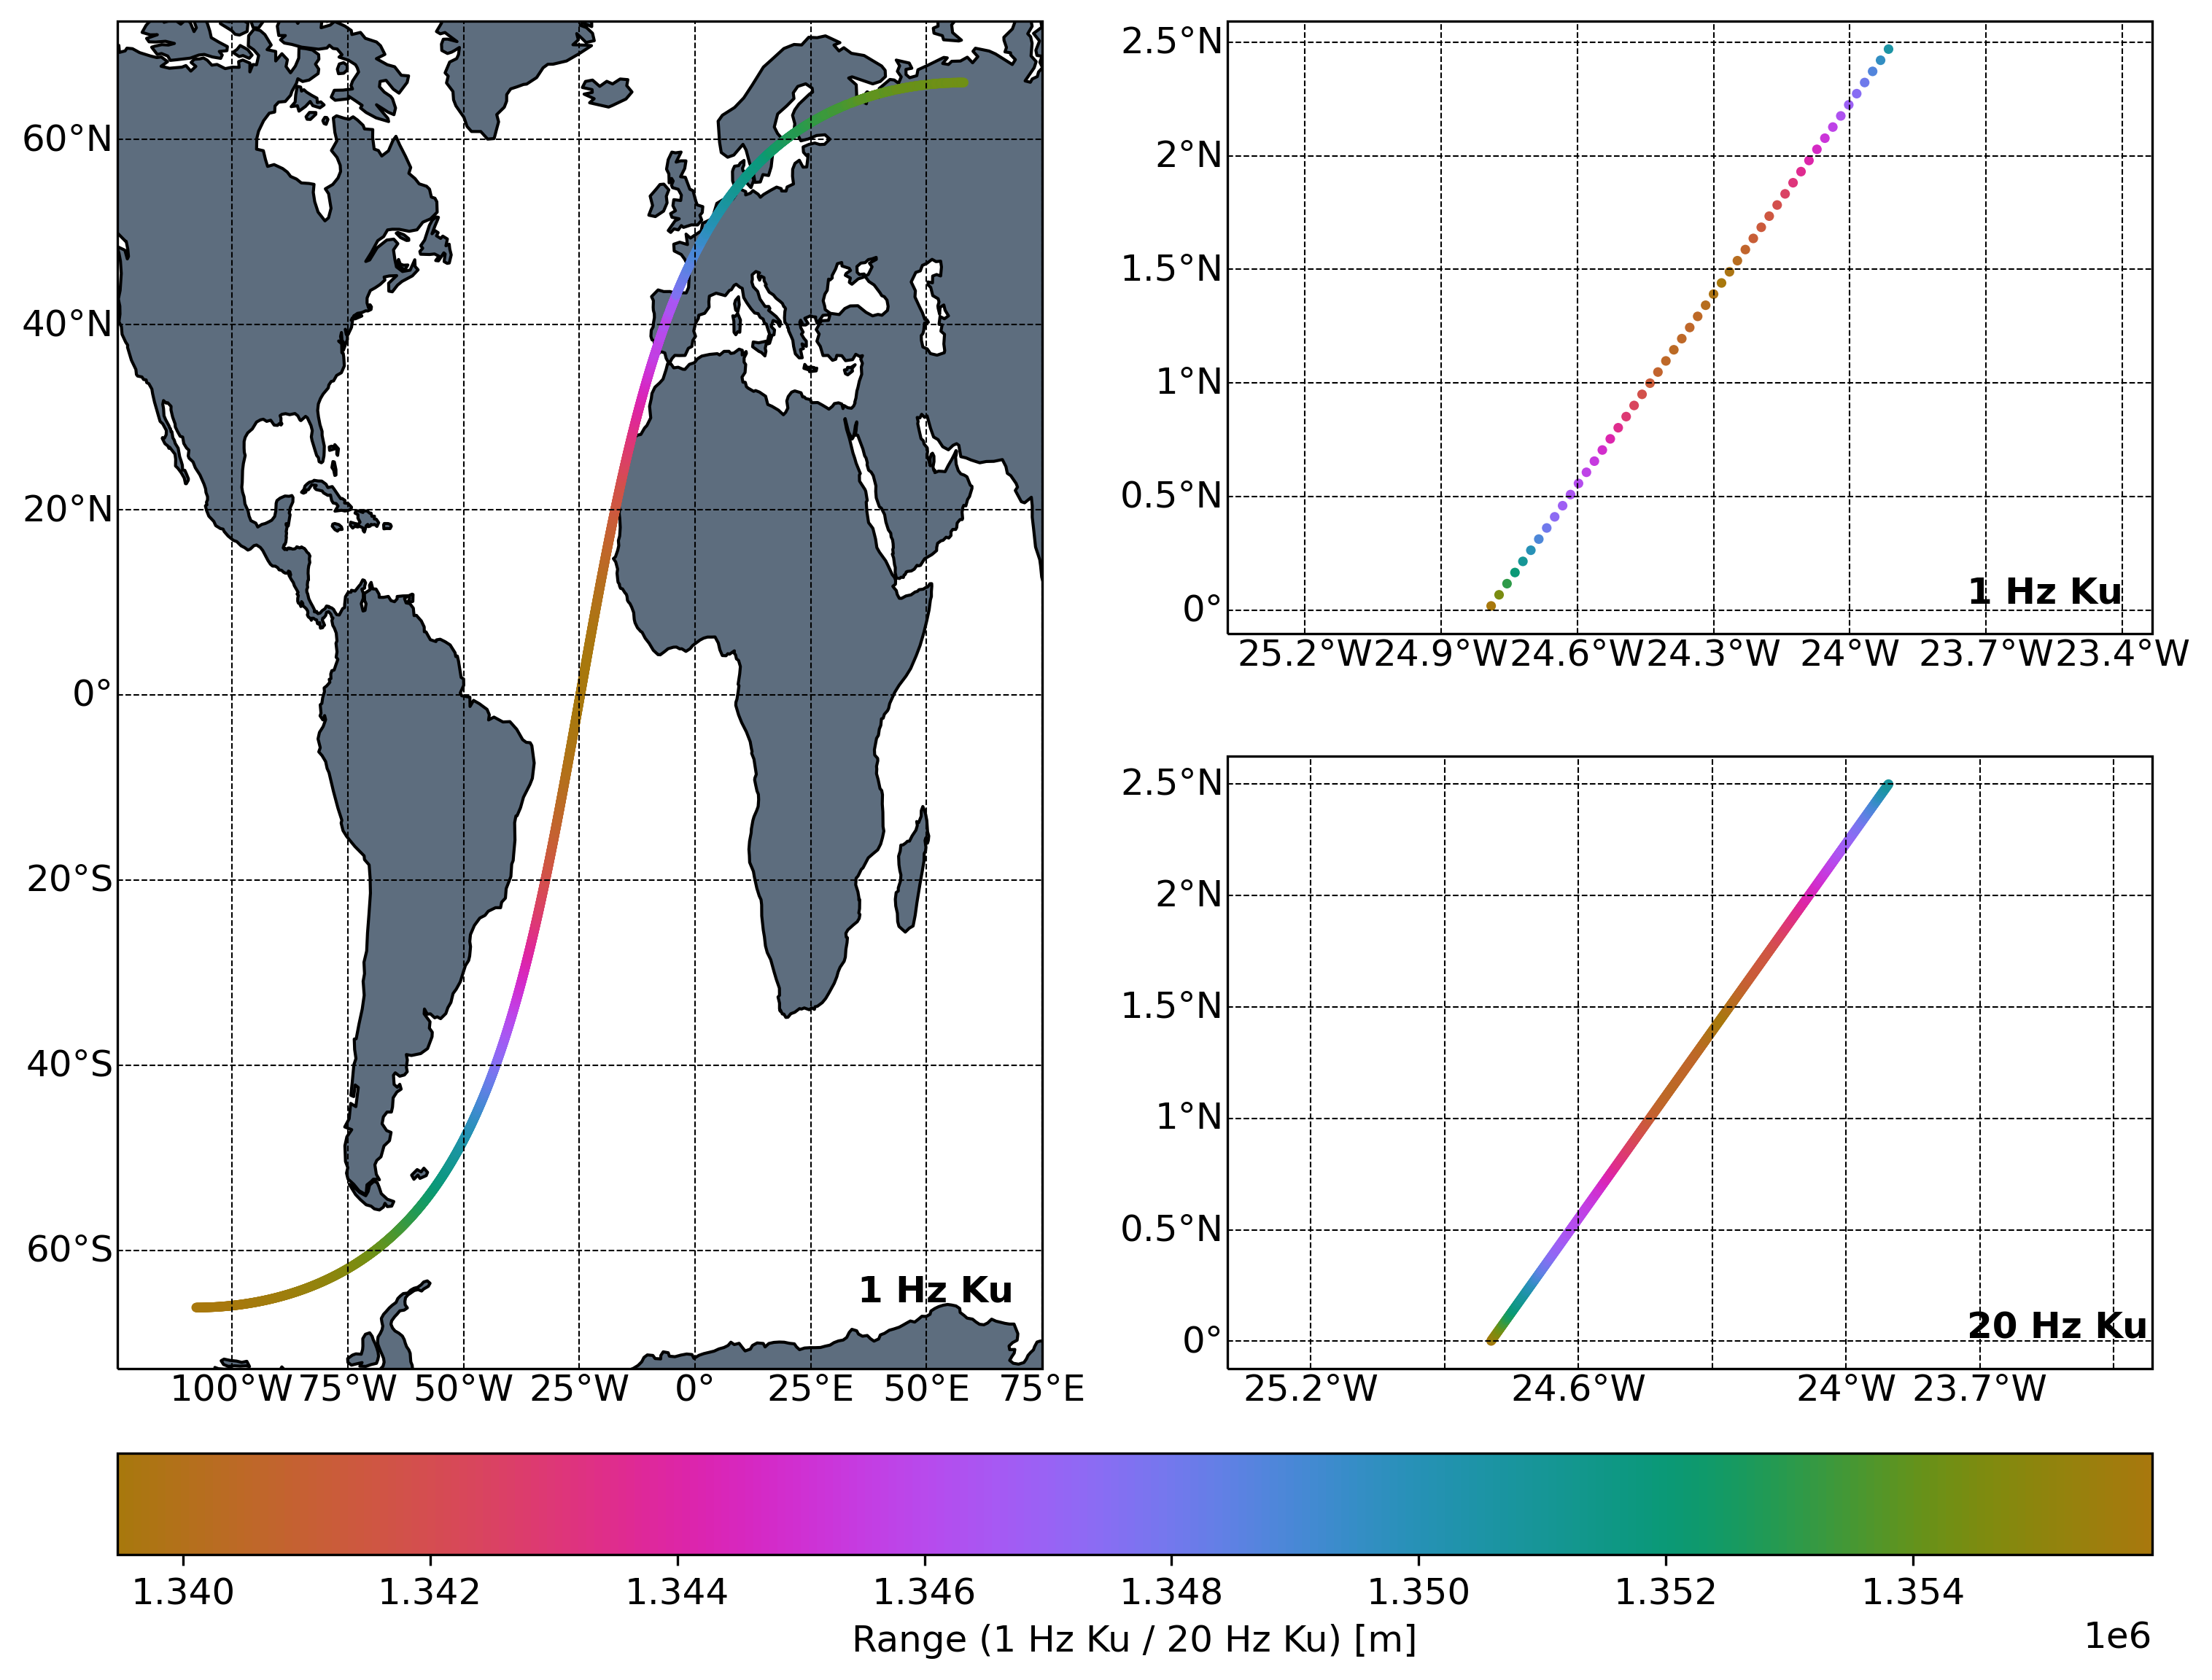

In [5]:
fig = plt.figure(figsize=(12, 10), dpi=300)
axs = [plt.subplot(121, projection=cartopy.crs.PlateCarree()),
       plt.subplot(222, projection=cartopy.crs.PlateCarree()),
       plt.subplot(224, projection=cartopy.crs.PlateCarree())]

lon_vars = [ds_01.longitude, ds_01.longitude, ds_20_ku.longitude]
lat_vars = [ds_01.latitude, ds_01.latitude, ds_20_ku.latitude]
plot_vars = [ds_01_ku.range_ocean, ds_01_ku.range_ocean, ds_20_ku.range_ocean]

for m, lon, lat, plot_var, annot in zip(axs, lon_vars, lat_vars, plot_vars, ['1 Hz Ku', '1 Hz Ku', '20 Hz Ku']):
    if m == axs[0]:
        f1 = m.scatter(lon, lat, c=plot_var, cmap=cmocean.cm.phase, 
                       s=10, marker='o', edgecolors=None, linewidth=0.0, zorder=1)
    else:
        ii = np.where((lat>0) & (lat<2.5))
        f2 = m.scatter(lon[ii], lat[ii], c=plot_var[ii], cmap=cmocean.cm.phase, 
                       s=10, marker='o', edgecolors=None, linewidth=0.0, zorder=1)
    
    m.annotate(annot, (0.8, 0.05), xycoords='axes fraction', color='k', fontweight='bold')

    m.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='k', facecolor='#5D6D7E')
    g1 = m.gridlines(draw_labels = True, zorder=20, color='0.0', linestyle='--', linewidth=0.5)
    g1.top_labels = False
    g1.right_labels = False
    g1.xlabel_style = {'color': 'black'}
    g1.ylabel_style = {'color': 'black'}
    m.set(facecolor = "1.0")
    if m == axs[0]:
        m.set_aspect(2)
        m.set_adjustable('datalim')
    else:
        m.set_aspect(0.5)
        m.set_adjustable('datalim')        

cbar = plt.colorbar(f1, ax=axs, orientation="horizontal", pad=0.05)
cbar.set_label('Range (1 Hz Ku / 20 Hz Ku) [m]')
plt.savefig('1_4_S6_tracks.png')
plt.show()

In the figure above, in the left hand panel, you can see a simple plot of the range measured along the entire track in the example file. This is a level-2 NTC HR file, and as such it is distributed in half orbits (aka 'passes' or 'tracks') as discussed in the previous notebook. In this panel, we have plotted the lower resolution 1 Hz data. For a global scale plot such as this, the 1 Hz resolution is more than suitable to capture the variability in the range. Looking at the two figures in the right hand panel, you can see the different in the resolution more clearly when we zoom in on a subset of the data. Now, with the range here you can see that you don't really need the additional resolution as there's not much variability apparent/the data is very smooth all along the track. The raw range shows mostly the altitude and its variations along the gravity field, with respect to the reference ellipsoid (purely geometric shape approximating the sea level).
The choice between 1 Hz and 20 Hz depends on your use (and your area of study). It also depends on the accuracy you need, since 20 Hz data are noisier than 1 Hz (less so in HR than in LR mode).

Note that the use of NRT, STC or NTC depends on your need for a (short) delay, but has an impact on the orbit quality - the longer you wait, the better the orbit, and for NRT on some of the corrections (coming from models instead of radiometer measurements). If you need accuracy but not quick-delivery, priviledge NTC data. 


<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Checking Sentinel-6 level-2 flags
[Back to top](#TOC_TOP)

</div>

A very important aspect of processing and/or working with any remote sensing product is understanding if there are any issues, errors, uncertainties etc associated with the data. To support this, data is quality flagged from the earliest levels. For Sentinel-6 altimetry products, many flags are available to assess the quality of the measurements and the geophysical products derived from them. You can usually get a good idea from the flag names, as to which products they are relevant for. EUMETSAT also provides guidance on which flags should be used for different products (as well as in which circumstances users may want to consider using flags or not).

In the first cell of code below, we'll retrieve the relevant flags for the range from the example data product we opened initially. We'll also retrieve some of the flags for the geophysical products, just to see how these compare. For each flag, we'll create two masks: one where the flag is raised that we set to an arbitrary value so that we can visualise them all over the track; the second mask we will set all locations where the flag isn't raised, to NaN so these don't appear in our plot. You could also do this vice versa, so that you can overlay a mask of NaNs where the flag is raised, over the data, to exclude those values.

In [6]:
# get the relevant flags
flags_range = np.array(ds_01_ku.range_ocean_qual).astype(float)
flags_range[flags_range != 0.0] = 1.1
flags_range[flags_range == 0.0] = np.nan

flags_swh = np.array(ds_01_ku.swh_ocean_qual).astype(float)
flags_swh[flags_swh != 0.0] = 1.15
flags_swh[flags_swh == 0.0] = np.nan

flags_ws = np.array(ds_01_ku.sig0_ocean_qual).astype(float)
flags_ws[flags_ws != 0.0] = 1.2
flags_ws[flags_ws == 0.0] = np.nan

flags_ssha = np.array(ds_01_ku.range_ocean_qual).astype(float) \
           + np.array(ds_01.surface_classification_flag).astype(float) \
           + np.array(ds_01.rad_surface_type_flag).astype(float)
flags_ssha[flags_ssha != 0.0] = 1.25
flags_ssha[flags_ssha == 0.0] = np.nan

In [7]:
# normalise the range to help with plotting
norm_range = ds_01_ku.range_ocean
norm_range = (norm_range - np.nanmin(norm_range)) / (np.nanmax(norm_range) - np.nanmin(norm_range))

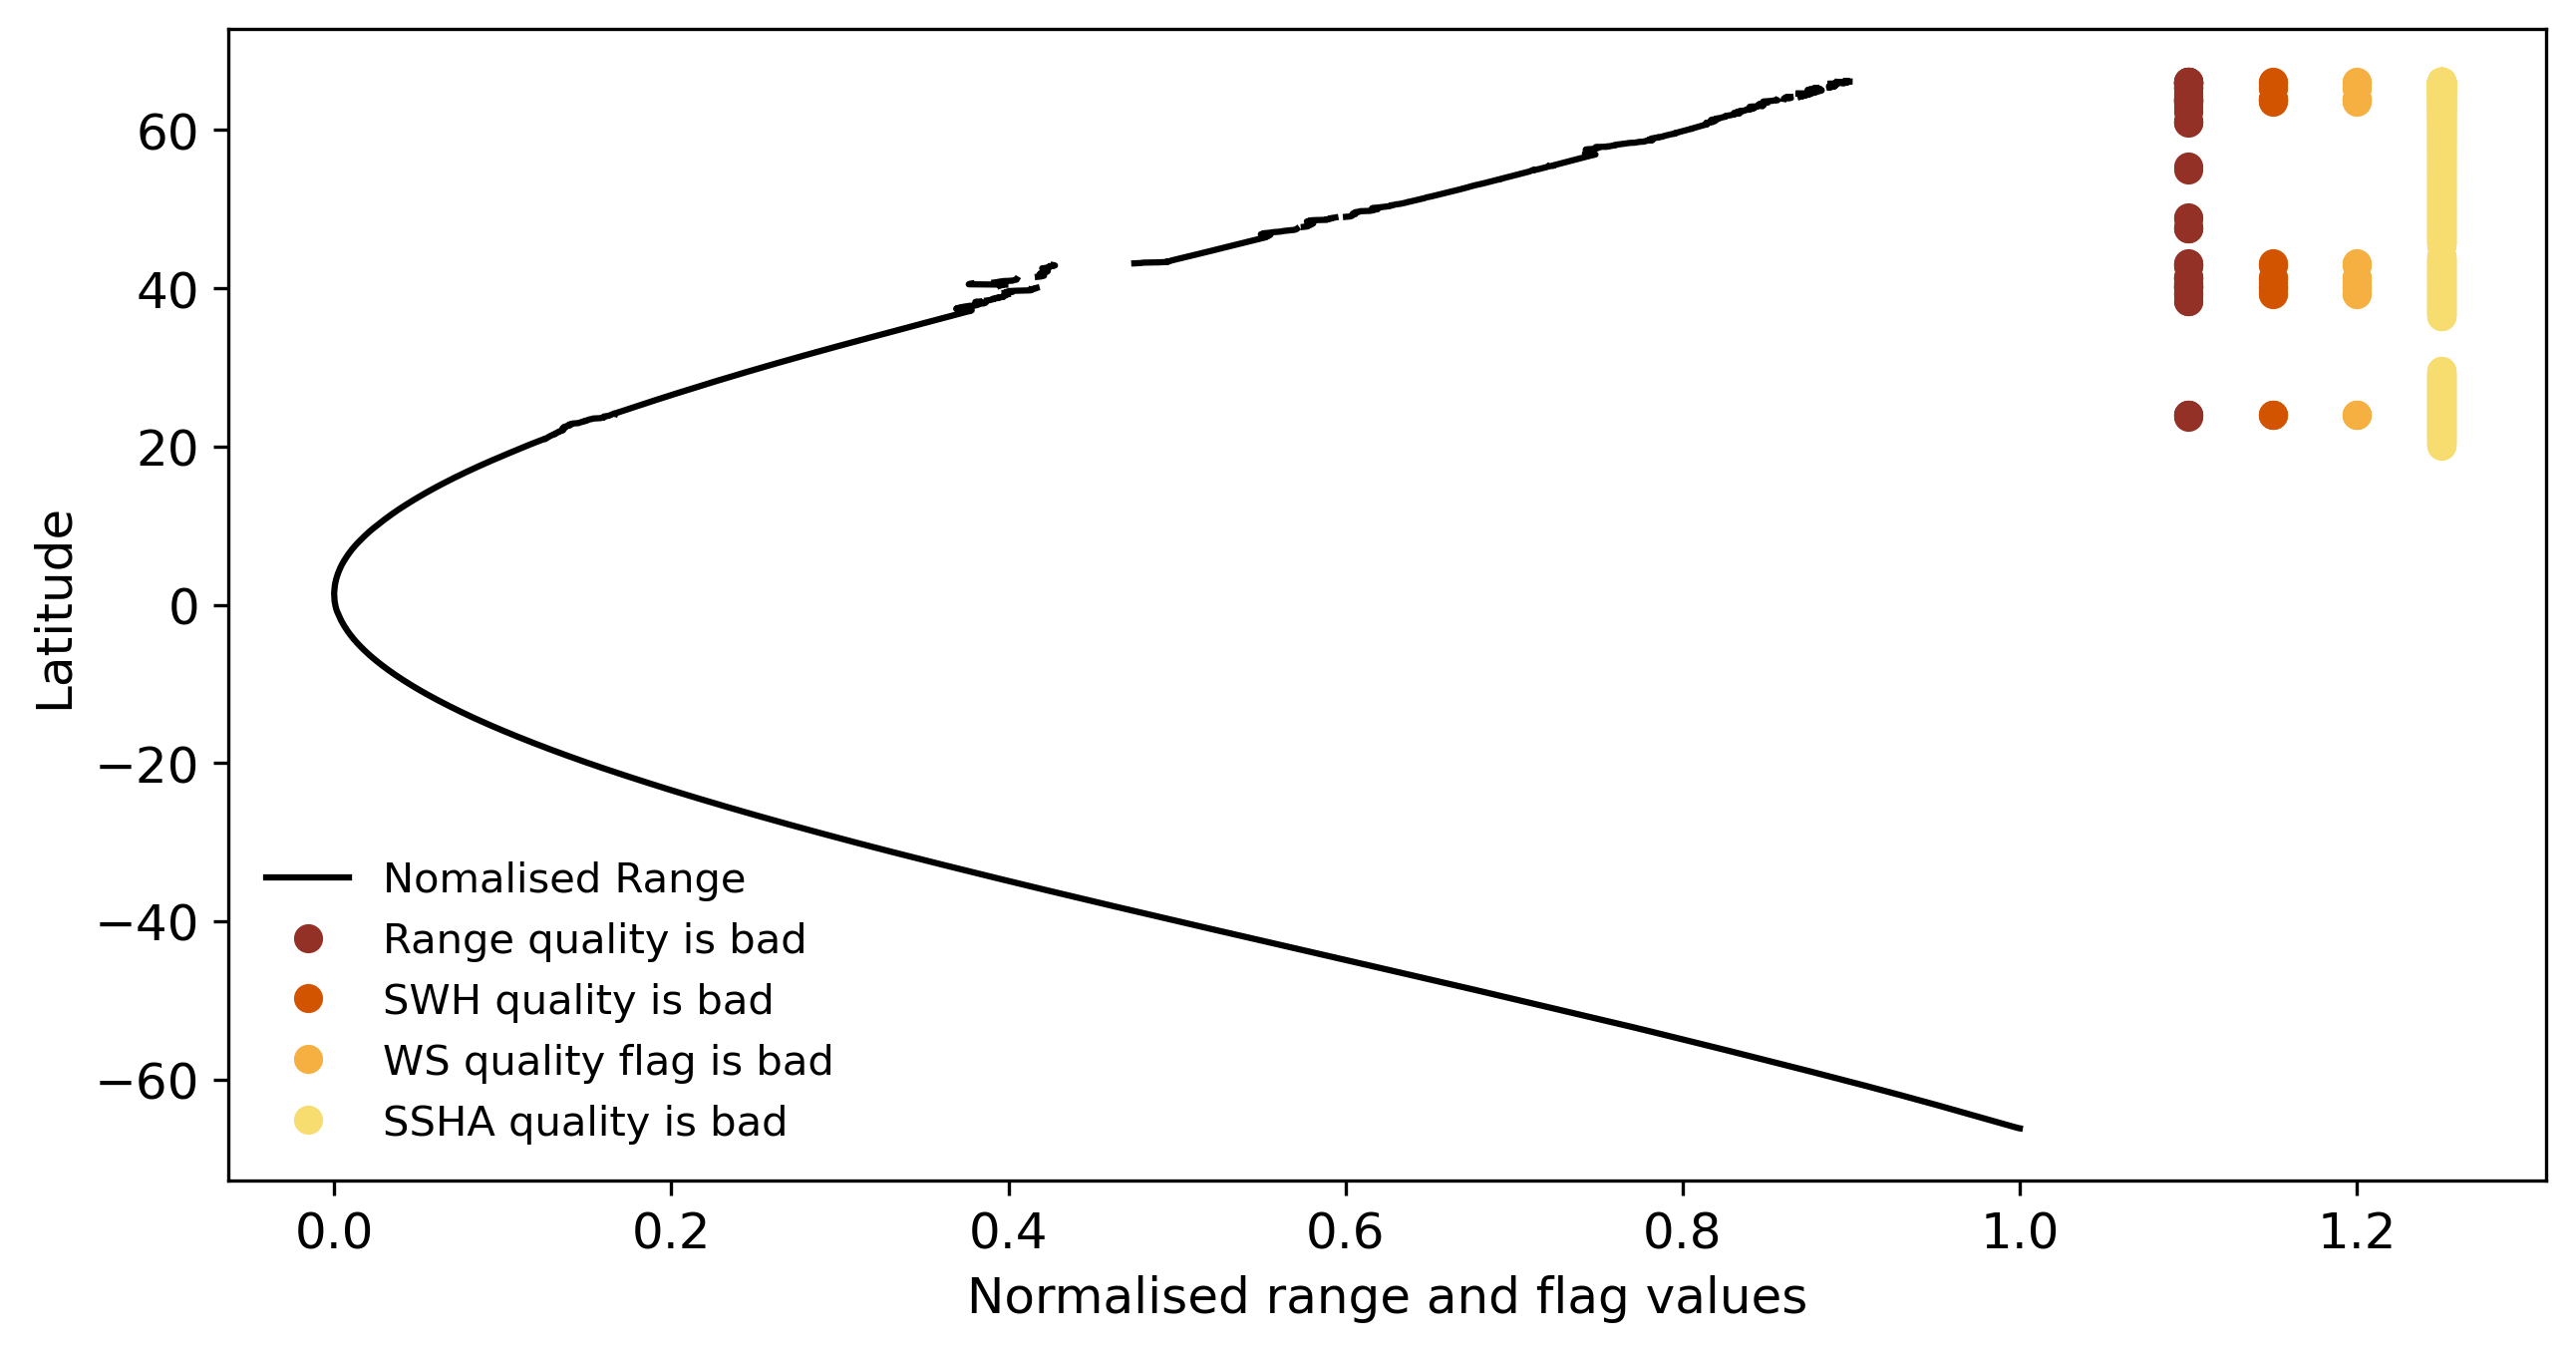

In [8]:
# plot the flags and normalised range
fig, axs = plt.subplots(1, 1, figsize=(10, 5), dpi=300)
p1, = axs.plot(norm_range, ds_01.latitude, 'k', label='Nomalised Range')
p2, = axs.plot(flags_range, ds_01.latitude, '#943126', marker='o', linewidth=0.0, label='Range quality is bad')
p3, = axs.plot(flags_swh, ds_01.latitude, '#D35400', marker='o', linewidth=0.0, label='SWH quality is bad')
p4, = axs.plot(flags_ws, ds_01.latitude, '#F5B041', marker='o', linewidth=0.0, label='WS quality flag is bad')
p5, = axs.plot(flags_ssha, ds_01.latitude, '#F7DC6F', marker='o', linewidth=0.0, label='SSHA quality is bad')
plt.xlabel('Normalised range and flag values')
plt.ylabel('Latitude')

handles, labels = axs.get_legend_handles_labels()
plt.legend(handles, labels, loc='lower left', fontsize=10, frameon=False)
plt.show()

In the plot above you can see the range (normalised for ease of plotting), and the locations along the track (in terms of latitude) where the flags we selected are raised. You can see that where the range quality is bad, this influences the geophysical products, which also have their respective flags raised. However, other factors can also influence the validity of the processing of the geophysical products. For example, you can see there is another instance in the lower latitudes where the quality of the sea surface height anomaly (SSHA). In the following notebooks you can learn more about these geophysical variables.

<hr>
<a href="../Index.ipynb"><< Index</a>
<br>
<a href="./1_4_S6_coverage.ipynb"><< Determining Sentinel-6 coverage</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_4_S6_waveforms.ipynb">Sentinel-6 waveforms >></a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>